In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
import keras.backend as K
from keras.utils import to_categorical, image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass
from keras.applications import ResNet50
from keras.layers import Input
from load_oasis_set_win import load_oasis_set

keras.backend.clear_session()



### Load Train Set

In [2]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 3071 files belonging to 4 classes.


In [3]:
# show that channels are just duplicates
for l, p in train_ds.unbatch().take(5):
    if np.array_equal(l[:,:,0],l[:,:,1]):
        print("channel 0 and 1; shape and elements are equal")
    if not np.array_equal(l[:,:,0],l[:,:,1]):
        print("channel 0 and 1; shape and elements are unequal")

# delete channel 2 and 3
train_ds = train_ds.map(lambda x, y: (x[:,:,:,0],y))
train_ds = train_ds.map(lambda x, y: (x[:,:,:,np.newaxis],y))

channel 0 and 1; shape and elements are equal
channel 0 and 1; shape and elements are equal
channel 0 and 1; shape and elements are equal
channel 0 and 1; shape and elements are equal
channel 0 and 1; shape and elements are equal


### Load Validation Set
<i>-for training-<i>

In [4]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 2050 files belonging to 4 classes.


In [5]:
# show that channels are just duplicates
for l, p in val_ds.unbatch().take(5):
    if np.array_equal(l[:,:,0],l[:,:,1]):
        print("channel 0 and 1; shape and elements are equal")
    if not np.array_equal(l[:,:,0],l[:,:,1]):
        print("channel 0 and 1; shape and elements are unequal")

# delete channel 2 and 3
val_ds = val_ds.map(lambda x, y: (x[:,:,:,0],y))
val_ds = val_ds.map(lambda x, y: (x[:,:,:,np.newaxis],y))

channel 0 and 1; shape and elements are equal
channel 0 and 1; shape and elements are equal
channel 0 and 1; shape and elements are equal
channel 0 and 1; shape and elements are equal
channel 0 and 1; shape and elements are equal


### Load Validation Set
<i>-deconstruct for evaluation-<i>

In [6]:
# NOT SHUFFLED load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_no_shuffle = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<--- shuffel is OFF. dataset is shuffeled in next step
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_no_shuffle = val_no_shuffle.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 2050 files belonging to 4 classes.


In [7]:
# seperate images and labels for evaluation.

X_val = []
y_val = []

for img, label in val_no_shuffle.unbatch():
    X_val.append(img.numpy()[:,:,0])                            #<--- delete channel 1 and 2
    y_val.append(label.numpy())
    
X_val = np.array(X_val)
y_val = np.array(y_val)

X_val, y_val = shuffle(X_val, y_val, random_state=10)

### Visualize Example Brains

f:\alzheimer-classification\envwin\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


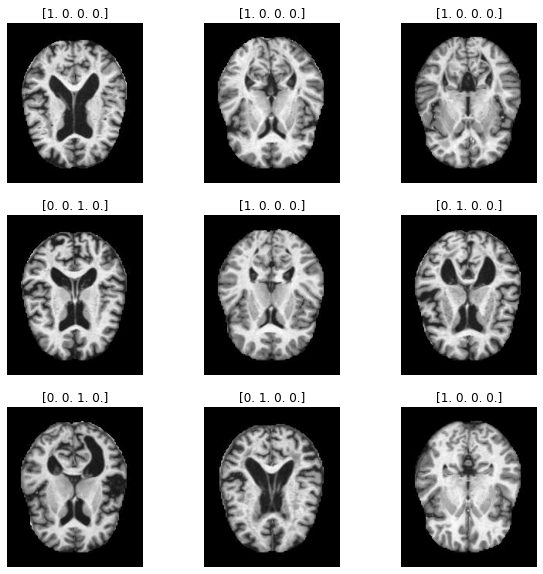

In [8]:
# # plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy(), cmap="gray")
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

In [9]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 208, 176, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

### Build CNN Architecture and Model Fitting

In [10]:
inputs = Input(shape = (208, 176, 1))

In [11]:
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=inputs,
    input_shape=None,
    pooling=None,
    classes=4,
)


In [12]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 208, 176, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 214, 182, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 104, 88, 64)  3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 104, 88, 64)  256         ['conv1_conv[0][0]']      

In [13]:
s

NameError: name 's' is not defined

In [ ]:
tf.keras.applications.resnet50.preprocess_input

<function keras.applications.resnet.preprocess_input(x, data_format=None)>

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=train_ds.cardinality().numpy()*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')


In [ ]:
#compiling the model architecture and start fit
keras.backend.clear_session()
model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall()])


with tf.device("/gpu:0"):
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=20, 
                        shuffle=True,               #not sure if used with batched tf dataset
                        )
                        
                    

Epoch 1/20
96/96 [==============================] - 18s 126ms/step - loss: 1.2200 - precision: 0.5491 - recall: 0.4751 - val_loss: 1.1256 - val_precision: 0.6883 - val_recall: 0.1034
Epoch 2/20
96/96 [==============================] - 11s 113ms/step - loss: 0.8562 - precision: 0.6977 - recall: 0.6389 - val_loss: 1.5424 - val_precision: 0.3498 - val_recall: 0.3498
Epoch 3/20
96/96 [==============================] - 11s 114ms/step - loss: 0.6678 - precision: 0.7692 - recall: 0.7271 - val_loss: 1.3381 - val_precision: 0.5798 - val_recall: 0.5493
Epoch 4/20
96/96 [==============================] - 11s 114ms/step - loss: 0.4888 - precision: 0.8329 - recall: 0.8069 - val_loss: 0.8720 - val_precision: 0.7080 - val_recall: 0.6776
Epoch 5/20
96/96 [==============================] - 11s 114ms/step - loss: 0.3759 - precision: 0.8673 - recall: 0.8531 - val_loss: 1.9873 - val_precision: 0.5852 - val_recall: 0.5678
Epoch 6/20
96/96 [==============================] - 11s 114ms/step - loss: 0.2340 - p

### Model Evaluation

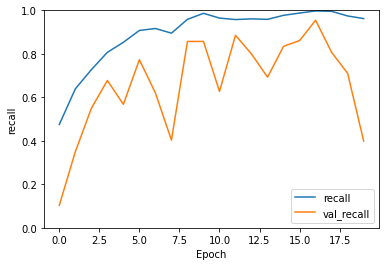

In [ ]:
#print val vs accuracy

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [ ]:
oasis_images, oasis_labels = load_oasis_set()
oasis_images = oasis_images[:,:,:,0]
oasis_images = oasis_images[:,:,:,np.newaxis]



Image Array Shape: (231, 208, 176, 3) 

Image Count: 231 

labels: [0. 1. 2. 3.] 

Class Counts:
      ID
CDR     
0.0  131
1.0   70
2.0   28
3.0    2


In [ ]:
oasis_labels_hot = np.zeros((len(oasis_labels),4))

for labels, hot in zip(oasis_labels,oasis_labels_hot):
    if labels == 1:
        hot[1] = 1
    if labels == 2:
        hot[2] = 1
    if labels == 3:
        hot[3] = 1

In [ ]:

y_pred = model.predict(oasis_images, batch_size=1, verbose=1)

#test_loss, test_prec, test_rec, test_auc  = model.evaluate(val_ds, verbose=2)

231/231 [==============================] - 3s 9ms/step


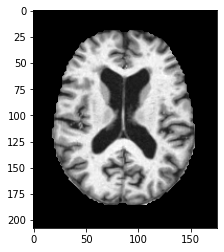

In [ ]:
plt.imshow(oasis_images[1], cmap="gray")

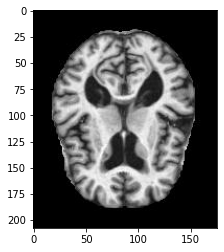

In [ ]:
plt.imshow(X_val[3], cmap="gray")

f:\alzheimer-classification\envwin\lib\site-packages\sklearn\metrics\_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


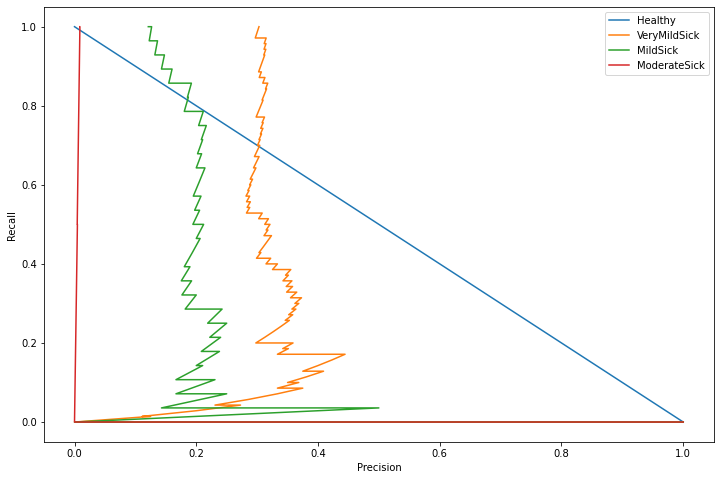

In [ ]:
precision_recall_multiclass(y_pred,oasis_labels_hot,['Healthy','VeryMildSick','MildSick','ModerateSick'])

In [ ]:
#!mkdir -p saved_model2
#model.save("saved_model/model2")